# Criação de um classificador de Texto com KNN

Passos que serão realizados:

* Carregar os dados
* Separar entre treino e teste
* Criar validação cruzada com o conjunto de treino
* Criar as features com TF-IDF
* Selecionar o modelo vencedor
* Fazer análise das figuras de mérito levando em conta os datasets de validação (da validação cruzada)
* Fazer análise das figuras de mérito do conjunto de teste para compreender a capacidade de generalização do modelo.


## Importação de bibliotecas e pacotes de interesse


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve,
                             RocCurveDisplay)
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import numpy as np

## Carregar os dados

In [ ]:
targets = []
docs = []
with open('movie-pang02.csv') as movies:
    for line in movies.readlines()[1:]:
        line_list = line.split(',')
        targets.append(line_list[0])
        docs.append(line_list[1].strip())

targets =[1. if t=="Pos" else 0. for t in targets]


## Separação em treino e teste

In [ ]:
docs_train, docs_test, y_train, y_test = train_test_split(docs,
                                                          targets,
                                                          random_state=123,
                                                          test_size=0.2,
                                                          stratify=targets)

## Validação Cruzada para criar um modelo de KNN

In [ ]:
n_splits = 5
kfolds = KFold(n_splits=5)
n_neighbors = list(range(5, 25, 5))

### Funções auxiliares

In [ ]:
def create_classifier(n_neighbors):
    return KNeighborsClassifier(n_neighbors=n_neighbors)

def encode_input(train, validation):
    tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        min_df = 10,
        max_features=5000,
        token_pattern=r'[a-z]+'
    )
    return (tfidf,
            tfidf.fit_transform(train),
            tfidf.transform(validation))

def train(model, X, y):
    model.fit(X, y)
    return model

def score(y_true, y_pred):
    return {
            'accuracy': accuracy_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'cm': confusion_matrix(y_true, y_pred),
        }


### Loop de validação

In [ ]:
from copy import deepcopy
results = []

for nn in tqdm(n_neighbors):
    results_folds = []
    for fold, (train_idx, val_idx) in tqdm(enumerate(kfolds.split(y_train))):
        knn = create_classifier(nn)
        # Encode TF-IDF
        docs_train_fold, y_train_fold = np.array(docs_train)[train_idx],  np.array(y_train)[train_idx]
        docs_val_fold, y_val_fold = np.array(docs_train)[val_idx], np.array(y_train)[val_idx]
        tfidf_fold, X_train_fold, X_val_fold = encode_input(docs_train_fold, docs_val_fold)
        # Training
        knn = train(knn, X_train_fold, y_train_fold)
        y_val_pred = knn.predict(X_val_fold)
        y_train_pred = knn.predict(X_train_fold)
        # Assess performance
        result ={
            'tfidf': deepcopy(tfidf_fold),
            'fold': fold,
            'train': score(y_train_fold, y_train_pred),
            'validation': score(y_val_fold, y_val_pred),
            'model': deepcopy(knn)
        }
        results_folds.append(result)
    results.append({
        'k': nn,
        'result': results_folds
    })

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
for item in results:
    print(f"KNN - K usado: { item['k']}")
    knn_results = item['result']
    f1_train = [fold['train']['f1'] for fold in knn_results]
    f1_validation = [fold['validation']['f1'] for fold in knn_results]
    print(f"Treino: {np.mean(f1_train):.2f} ± {np.std(f1_train):.2f}")
    print(f"Validação: {np.mean(f1_validation):.2f} ± {np.std(f1_validation):.2f}")

    print()
    print()

KNN - K usado: 5
Treino: 0.80 ± 0.01
Validação: 0.68 ± 0.02


KNN - K usado: 10
Treino: 0.73 ± 0.01
Validação: 0.63 ± 0.03


KNN - K usado: 15
Treino: 0.75 ± 0.00
Validação: 0.67 ± 0.01


KNN - K usado: 20
Treino: 0.72 ± 0.01
Validação: 0.66 ± 0.03




In [ ]:
best_nn = 0

results[best_nn]

for result_fold in results[best_nn]['result']:
    print(f"{result_fold['fold']} - {result_fold['train']['f1']:.3f} - {result_fold['validation']['f1']:.3f}")

0 - 0.784 - 0.667
1 - 0.796 - 0.691
2 - 0.793 - 0.690
3 - 0.800 - 0.687
4 - 0.810 - 0.646


In [ ]:
best_fold = 1
best_model = results[best_nn]['result'][best_fold]['model']
best_tfidf = results[best_nn]['result'][best_fold]['tfidf']

## Analisar performance do teste

In [ ]:
X_test = best_tfidf.transform(docs_test)
y_test_pred = best_model.predict(X_test)
scores_test = score(y_test, y_test_pred)

In [ ]:
scores_test

{'accuracy': 0.66,
 'recall': 0.73,
 'precision': 0.6403508771929824,
 'f1': 0.6822429906542056,
 'cm': array([[118,  82],
        [ 54, 146]])}

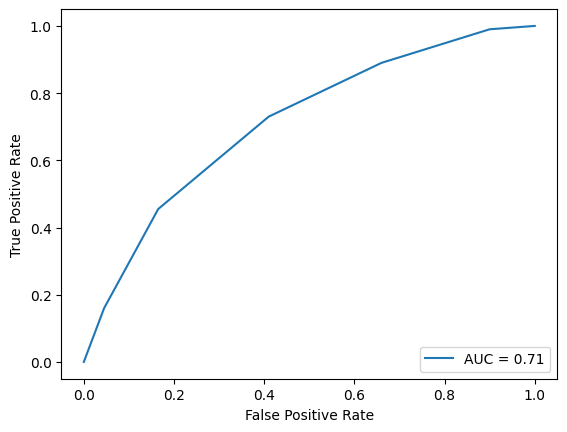

In [ ]:
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(lw=2)

plt.grid()